In [95]:
import pandas as pd

In [96]:
data = pd.read_csv("train.csv")

In [97]:
data.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


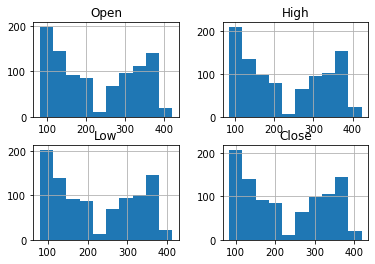

In [99]:
import matplotlib.pyplot as plt

data_used = data.iloc[:, 1:4]
data_used["Close"] = data["Close"]
hist = data_used.hist()
plt.show()

In [100]:
import numpy as np

from torch.utils.data.dataset import Dataset

class Netflix(Dataset):
    def __init__(self):
        #Read data
        self.csv = pd.read_csv("train.csv")    
        
        #Normalize input data
        self.data = self.csv.iloc[:, 1:4].values #Data excluding closing price
        self.data = self.data / np.max(self.data) #Normalize between 0 and 1
        
        #Closing Data Normalization
        self.label = data["Close"].values
        self.label = self.label / np.max(self.label)

    def __len__(self):
        return len(self.data) - 30 #Number of available batches

    def __getitem__(self, i):
        data = self.data[i:i+30] #30 days' worth of input data
        label = self.label[i+30] #30 days' worth of closing data
        
        return data, label

In [101]:
import torch
import torch.nn as nn

In [104]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        #RNN
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
        
        #MLP Predicts Stock Price
        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)
        
        #Activation function
        self.relu = nn.ReLU()

    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)
    
        x = torch.reshape(x, (x.shape[0], -1))
    
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
    
        x = torch.flatten(x)
    
        return x

In [105]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

#Model
model = RNN().to(device)
dataset = Netflix()

In [106]:
#Dataloader
loader = DataLoader(dataset, batch_size=32)
#Optimization
optim = Adam(params=model.parameters(), lr=0.0001)

In [107]:
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()
        
        h0 = torch.zeros(5, data.shape[0], 8).to(device)
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        
        loss.backward()
        optim.step()
        
        iterator.set_description(f"epoch{epoch}  loss:{loss.item()}")
        
torch.save(model.state_dict(), "./rnn.pth")
        

epoch94  loss:0.0030853720381855965: 100%|██████████| 30/30 [00:00<00:00, 35.01it/s] 


epoch188  loss:0.0011455845087766647: 100%|██████████| 30/30 [00:01<00:00, 21.32it/s] 


epoch199  loss:0.0008492905180901289: 100%|██████████| 30/30 [00:01<00:00, 29.32it/s] 


In [112]:
#Test the model
loader = DataLoader(dataset, batch_size=1)

preds = []
total_loss = 0

with torch.no_grad():
    model.load_state_dict(torch.load("rnn.pth", map_location=device))
    
    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 8).to(device)
        
        pred = model(data.type(torch.FloatTensor).to(device), h0)
        preds.append(pred.item())
        
        loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))
        
        total_loss += loss/len(loader)
        
total_loss.item()

0.0016307401238009334

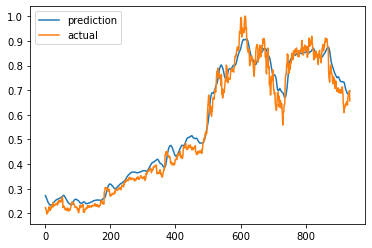

In [113]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()